# Utilizing Undirected Graphs to Optimize the Travel-Time Between Towns

In business logistics, product delivery time can impact certain critical decisions. Consider the following scenario, in which you’ve opened your own kombucha brewery. Your plan is to deliver batches of the delicious fermented tea to all the towns within a reasonable driving radius. More specifically, you’ll only deliver to a town if it’s within a two-hour driving distance of the brewery; otherwise, the gas costs won’t justify the revenue from that delivery. A grocery store in a neighboring county is interested in regular deliveries. What is the fastest driving time between your brewery and that store?

Normally, you could obtain the answer by searching for directions on a smartphone, but we’ll assume that existing tech solutions are not available (perhaps the area is remote and the local maps have not been scanned into an online database). In other words, you need to replicate the travel time computations carried out by existing smartphone tools. To do this, you consult a printed map of the local area. On the map, roads zigzag between towns, and some towns connect directly via a road. Conveniently, the travel times between connected towns are illustrated clearly on the map. We can model these connections using undirected graphs.

Suppose that a road connects two towns, _Town 0_ and _Town 1_. The driving time between the towns is 20 minutes. Lets record this information in an undirected graph.

**Creating a 2-node undirected graph**

In [ ]:
import networkx as nx

In [ ]:
G = nx.Graph()
G.add_edge(0, 1)
G[0][1]['travel_time'] = 20

Our travel-time is an attribute of the edge `(0, 1)`. Given an attribute `k` of edge `(i, j)`, we can access that attribute by running `G[i][j][k]`. Hence, we can access the travel-time by running `G[0][1]['travel_time']`.

**Checking the edge attribute of a graph**

In [ ]:
for i, j in [(0, 1), (1, 0)]:
    travel_time = G[i][j]['travel_time']
    print(f"It takes {travel_time} minutes to drive from Town {i} to Town {j}.")

It takes 20 minutes to drive from Town 0 to Town 1.
It takes 20 minutes to drive from Town 1 to Town 0.


Imagine an additional _Town 2_  that is connected to _Town 1_ but not _Town 0_. There is no road between _Town 0_ and _Town 2_. There is a road between  _Town 1_ and _Town 2_. The travel-time on that road is 15 minutes. Let's add this new connection to our graph. Afterwards, we'll visualize the graph using `nx.draw`.

**Visualizing a path between multiple towns**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

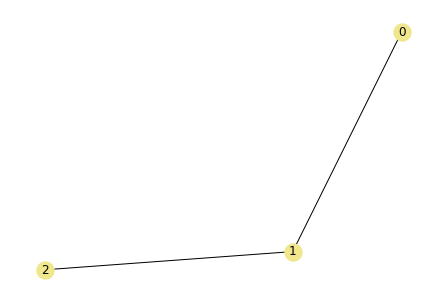

In [ ]:
np.random.seed(0)
G.add_edge(1, 2, travel_time=15)
nx.draw(G, with_labels=True, node_color='khaki')
plt.show()

Traveling from _Town 0_ to _Town 2_ requires us to first traverse _Town 1_. Hence, the total travel-time is equal to the sum of `G[0][1]['travel_time']` and `G[1][2]['travel_time']`.

**Computing the travel-time between towns**

In [ ]:
travel_time = sum(G[i][1]['travel_time'] for i in [0, 2])
print(f"It takes {travel_time} minutes to drive from Town 0 to Town 2.")

It takes 35 minutes to drive from Town 0 to Town 2.


Our computation was trivial, since there is just one route between _Town 0_ and _Town 2_. However, in real-life, many routes can exist between localized towns. Lets build a graph containing more than a dozen towns. These cities will be spread across multiple counties. Within our graph model, the travel-time between towns will increase when cities are in different counties. We'll assume that:

A. Our towns cover six different counties.

B. Each county contains 3 - 10 towns.

C. 90% of towns within a single county are directly connected by road.
* The average travel-time on a county road is 20 minutes.

D. 5% of cities across different counties are directly connected by a road.
*  The average travel-time across an intra-county road is 45 minutes

### Modeling a Complex Network of Cities and Counties

Lets start by modeling a single county that contains five towns.

**Modeling five towns in the same county**

In [ ]:
G = nx.Graph()
G.add_nodes_from((i, {'county_id': 0}) for i in range(5))

Next, we'll assign random roads to our five towns.

**Modeling random intra-county roads**

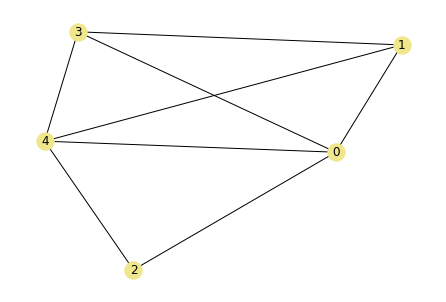

In [ ]:
np.random.seed(0)
def add_random_edge(G, node1, node2, prob_road=0.9, 
                    mean_drive_time=20):
    if np.random.binomial(1, prob_road):
        drive_time = np.random.normal(mean_drive_time)
        G.add_edge(node1, node2, travel_time=round(drive_time, 2))


nodes = list(G.nodes())
for node1 in nodes[:-1]:
    for node2 in nodes[node1 + 1:]:
        add_random_edge(G, node1, node2)
            
nx.draw(G, with_labels=True, node_color='khaki')
plt.show()

We've connected most of the towns in _County 0_. In this same manner, we can randomly generate roads and towns for a second county; _County 1_.

**Modeling a second random county**

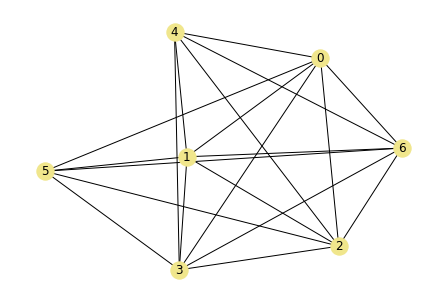

In [ ]:
np.random.seed(0)
def random_county(county_id):
    num_towns = np.random.randint(3, 10)
    G = nx.Graph()
    nodes = [(node_id, {'county_id': county_id})
            for node_id in range(num_towns)]
    G.add_nodes_from(nodes)
    for node1, _ in nodes[:-1]:
        for node2, _ in nodes[node1 + 1:]:
            add_random_edge(G, node1, node2)

    return G

G2 = random_county(1)
nx.draw(G2, with_labels=True, node_color='khaki')
plt.show()

Currently, _County 1_ and _County 2_ are stored  in two separate graphs; `G` and `G2`. We can combine these graphs together by executing `nx.disjoint_union(G, G2)`.

**Merging two separate graphs**

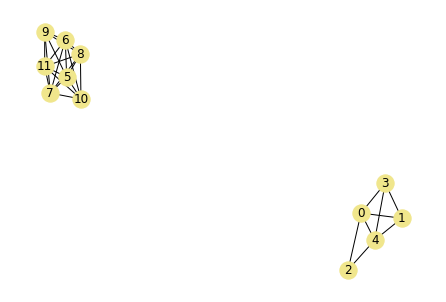

In [ ]:
np.random.seed(0)
G = nx.disjoint_union(G, G2)
nx.draw(G, with_labels=True, node_color='khaki')
plt.show()

Our two counties appear in the same graph. Each town in the graph is assigned a unique id. Now, it's time to generate random roads between the counties.


**Adding random inter-county roads**

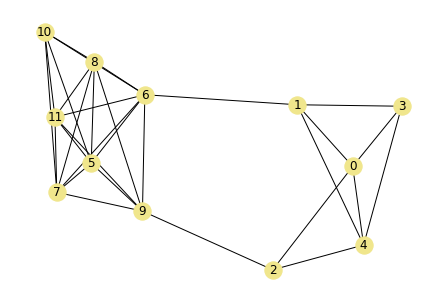

In [ ]:
np.random.seed(0)
def add_intracounty_edges(G):
    nodes = list(G.nodes(data=True))
    for node1, attributes1 in nodes[:-1]:
        county1 = attributes1['county_id']
        for node2, attributes2 in nodes[node1:]:
            if county1 != attributes2['county_id']:
                add_random_edge(G, node1, node2,
                                prob_road=0.05, mean_drive_time=45)
    return G

G = add_intracounty_edges(G)
np.random.seed(0)
nx.draw(G, with_labels=True, node_color='khaki')
plt.show()

We’ve successfully simulated two interconnected counties. Now, we’ll simulate six interconnected counties.

**Simulating six interconnected counties**

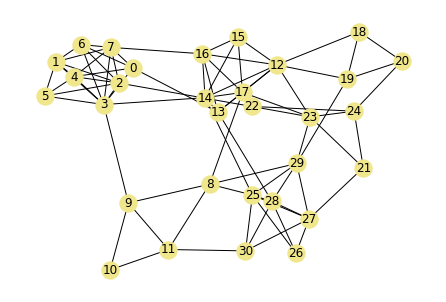

In [ ]:
np.random.seed(1)
G = random_county(0)
for county_id in range(1, 6):
    G2 = random_county(county_id)
    G = nx.disjoint_union(G, G2)

G = add_intracounty_edges(G)
np.random.seed(1)
nx.draw(G, with_labels=True, node_color='khaki')
plt.show()

We’ve visualized our six-county graph. However, individual counties are tricky to decipher in the visualization. Fortunately, we can improve our plot by coloring each node based on county id. Doing so requires that we modify our input into the `node_color` parameter.

**Coloring nodes by county**

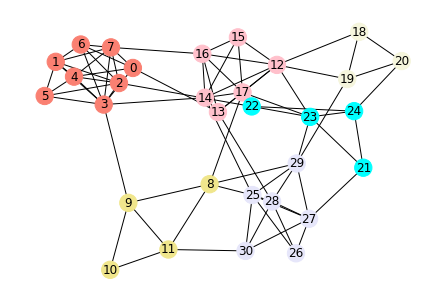

In [ ]:
np.random.seed(1)
county_colors = ['salmon', 'khaki', 'pink', 'beige', 'cyan', 'lavender']
county_ids = [G.nodes[n]['county_id'] 
              for n in G.nodes]
node_colors = [county_colors[id_] 
               for id_ in county_ids]
nx.draw(G, with_labels=True, node_color=node_colors)

The individual counties are now visible. Most counties form tight clumps within the network. Later, we’ll proceed to extract these clumps automatically, using network clustering. For now, however, we’ll focus our attention on computing the fastest travel-time between nodes.

### Computing the Fastest Travel-Time Between Nodes

Suppose we want to know the fastest travel-time between _Town 0_ and _Town 30_. In the process, we’ll need to compute the fastest travel-time between _Town 0_ and every other town. Initially, all we know is the trivial travel-time between _Town 0_ and itself; 0 minutes. Let’s record this travel-time in a `fastest_times` dictionary. 

**Tracking the fastest-known travel times**

In [ ]:
fastest_times = {0: 0}

Next, we can answer a simple question; what is the known travel-distance between _Town 0_ and its neighboring towns? In NetworkX, we can access the neighbors of _Town 0_ by executing `G.neighbors(0)`. Alternatively, we can access the neighbours simply by running `G[0]`.

**Accessing the neighbors of _Town 0_**

In [ ]:
neighbors = list(G.neighbors(0))
assert list(neighbors) == list(G[0])
print(f"The following towns connect directly with Town 0:\n{neighbors}")

The following towns connect directly with Town 0:
[3, 4, 6, 7, 13]


Now, we’ll record the travel-times between _Town 0_ and each of its five neighbors. We’ll use these times to update `fastest_times`.

**Tracking the travel-times to neighboring towns**

In [ ]:
time_to_neighbor = {n: G[0][n]['travel_time'] for n in neighbors}
fastest_times.update(time_to_neighbor)
for neighbor, travel_time in sorted(time_to_neighbor.items(), 
                                    key=lambda x: x[1]):
    print(f"It takes {travel_time} minutes to drive from Town 0 to Town "
          f"{neighbor}.")

It takes 18.04 minutes to drive from Town 0 to Town 7.
It takes 18.4 minutes to drive from Town 0 to Town 3.
It takes 18.52 minutes to drive from Town 0 to Town 4.
It takes 20.26 minutes to drive from Town 0 to Town 6.
It takes 44.75 minutes to drive from Town 0 to Town 13.


It takes approximately 45 minutes to drive from _Town 0_ to _Town 13_. Is this the fastest travel-time between these two towns? Not necessarily! It’s possible that a detour through another town will speed-up travel. Consider, for instance, a detour through _Town 7_. It’s our most proximate town, with a drive-time of only 18 minutes. What if there’s a road between _Town 7_ and _Town 13_?  If that road exists, and its travel-time is under 27 minutes, then a faster route to _Town 13_ is possible! We can potentially shave-off minutes from travel, if we examine the neighbors of _Town 7_. Lets carry-out that examination thusly:

1. First, we’ll obtain the neighbors of _Town 7_.

2. Next, we’ll obtain travel-time between _Town 7_ and every neighboring _Town N_.

3. We’ll add 18.4 minutes to the travel-time obtained in the previous step. This represents the travel-time between _Town 0_ and _Town N_, when we take a detour through _Town 7_.

4. If _N_ is present in `fastest_times`, we’ll check if the detour is faster than `fastest_times[N]`.

5. If _N_ is not present in `fastest_times`, then we will update that dictionary with the travel-time computed in Step 3.

**Searching for faster detours through _Town 7_**

In [ ]:
def examine_detour(town_id):
    detour_found = False
    
    travel_time = fastest_times[town_id]
    for n in G[town_id]:
        detour_time = travel_time + G[town_id][n]['travel_time']
        if n in fastest_times:
            if detour_time < fastest_times[n]:
                detour_found = True
                print(f"A detour through Town {town_id} reduces "
                      f"travel-time to Town {n} from "
                      f"{fastest_times[n]:.2f} to "
                      f"{detour_time:.2f} minutes.")
                fastest_times[n] = detour_time
        
        else:
            fastest_times[n] = detour_time
    
    return detour_found

if not examine_detour(7):
    print("No detours were found.")
    
added_towns = len(fastest_times) - 6
print(f"We've computed travel-times to {added_towns} additional towns.")

No detours were found.
We've computed travel-times to 3 additional towns.


We’ve uncovered travel-times to three additional towns. However, we have not uncovered any faster detours for travel to neighbors of _Town 0_. Lets choose another viable detour candidate. We’ll select a town that’s proximate to _Town 0_, whose neighbors we have not examined. Doing so requires that we:

1. Combine the neighbours of _Town 0_ and _Town 7_ into a pool of detour candidates.
2. Remove _Town 0_ and _Town 7_ from the pool of candidates, leaving behind a set of unexamined towns.
2. Select an unexamined town with the fastest known-travel distance to _Town 0_.

**Selecting an alternative detour candidate**

In [ ]:
candidate_pool = set(G[0]) | set(G[7])
examined_towns = {0, 7}
unexamined_towns = candidate_pool - examined_towns
detour_candidate = min(unexamined_towns, 
                       key=lambda x: fastest_times[x])
travel_time = fastest_times[detour_candidate]
print(f"Our next detour candidate is Town {detour_candidate}, "
      f"which is located {travel_time} minutes from Town 0.")

Our next detour candidate is Town 3, which is located 18.4 minutes from Town 0.


Our next detour candidate is _Town 3_. We’ll proceed to check _Town 3_ for detours.

**Searching for faster detours through _Town 3_**

In [ ]:
if not examine_detour(detour_candidate):
    print("No detours were found.")

def new_neighbors(town_id):
    return set(G[town_id]) - examined_towns

def shift_to_examined(town_id):
    unexamined_towns.remove(town_id)
    examined_towns.add(town_id)

unexamined_towns.update(new_neighbors(detour_candidate))
shift_to_examined(detour_candidate)
num_candidates = len(unexamined_towns)
print(f"{num_candidates} detour candidates remain.")

No detours were found.
9 detour candidates remain.


Once again, no detours were discovered. Nonetheless, nine detour candidates remain in our `unexamined_towns` set. Lets iteratively examine the remaining candidates. The code below will iteratively:

1. Select an unexamined town with the fastest known travel-time to _Town 0_.
2. Check that town for detours using `examine_detour`.
2. Shift the town’s id from `unexamined_towns` to `examined_towns`.
4. Repeat Step 1 if any unexamined towns remain. Terminate otherwise.

**Examining every town for faster detours**

In [ ]:
while unexamined_towns:
    detour_candidate = min(unexamined_towns, 
                       key=lambda x: fastest_times[x])
    examine_detour(detour_candidate)
    shift_to_examined(detour_candidate)
    unexamined_towns.update(new_neighbors(detour_candidate))

A detour through Town 14 reduces travel-time to Town 15 from 83.25 to 82.27 minutes.
A detour through Town 22 reduces travel-time to Town 23 from 111.21 to 102.38 minutes.
A detour through Town 28 reduces travel-time to Town 29 from 127.60 to 108.46 minutes.
A detour through Town 28 reduces travel-time to Town 30 from 126.46 to 109.61 minutes.
A detour through Town 19 reduces travel-time to Town 20 from 148.03 to 131.23 minutes.


We’ve examined the travel-time to every single town, and discovered five possible detours. Two of the detours reduce travel-times to _Towns 29_ and _30_ from 2.1 hours to 1.8 hours. How many other towns are within two hours of _Town 0_? Lets find out.

**Counting all the towns within a 2-hour driving range**

In [ ]:
close_towns = {town for town, drive_time in fastest_times.items()
               if drive_time <= 2 * 60}

num_close_towns = len(close_towns)
total_towns = len(G.nodes)
print(f"{num_close_towns} of our {total_towns} towns are within two "
      "hours of our brewery.")

29 of our 31 towns are within two hours of our brewery.


All but two of our towns are within two hours of the brewery. We’ve figured this out by solving the **shortest path length problem**. The problem applies to graphs whose edges contain numeric attributes, which are called **edge weights**. Additionally, a sequence of node-transitions in the graph is called a **path**. Each path occurs over a sequence of edges. The sum of edge weights in that sequence is called the **path length**. The problem asks us to compute the shortest path-lengths between some node _N_ and every single node within the graph.  A shortest path length detection algorithm is included in NetworkX.

**Computing shortest path-lengths with NetworkX**

In [ ]:
shortest_lengths = nx.shortest_path_length(G, weight='travel_time', 
                                           source=0)
for town, path_length in shortest_lengths.items():
    assert fastest_times[town] == path_length

In many real-word circumstances, we want to know the path that minimizes the distance between nodes. Calling `nx.shortest_path_length(G, weight=’weight’, source=N)` will compute all shortest paths from node _N_ to every node in G.

**Computing shortest paths with NetworkX**

In [ ]:
shortest_path = nx.shortest_path(G, weight='travel_time', source=0)[30]
print(shortest_path)

[0, 13, 28, 30]


Driving time is minimized if we travel from _Town 0_ to _Town 13_ to _Town 28_ and finally to _Town 30_. We expect that travel-time to equal `fastest_times[30]`. Lets confirm.

**Verifying the length of a shortest path**

In [ ]:
travel_time = 0
for i, town_a in enumerate(shortest_path[:-1]):
    town_b = shortest_path[i + 1]
    travel_time += G[town_a][town_b]['travel_time']

print("The fastest travel time between Town 0 and Town 30 is "
      f"{travel_time} minutes.")
assert travel_time == fastest_times[30]

The fastest travel time between Town 0 and Town 30 is 109.61 minutes.


### Uncovering Central Nodes Based on Expected Traffic within a Network

Suppose our business is growing at an impressive rate. We wish to expand our customer base by putting up a billboard advertisement in one of the local towns represented by G.nodes. To maximize billboard views, we’ll choose the town with the heaviest traffic. Intuitively, traffic is determined by the number of cars that pass through town every day. Can we rank the 31 towns in G.nodes based on the expected daily traffic? Yes, we can! Using simple modeling, we can predict traffic flow from the network of roads between the towns. Later, we’ll expand on these traffic-flow techniques to identify local counties in an automated manner.

We need a way of ranking the towns based on expected traffic. One naive solution is to just count the number of inbound roads into each town. The edge-count of a node within an undirected graph is simply called the node’s **degree**. We can compute the degree of any node `i` by summing over the ith column of the graph’s adjacency matrix. Or, we can measure the degree by running `len(G.nodes[i])`. Alternatively, we can utilize the NetworkX degree method by calling `G.degree(i)`.

**Computing the degree of a single node**

In [ ]:
adjacency_matrix = nx.to_numpy_array(G)
degree_town_0 = adjacency_matrix[:,0].sum()
assert degree_town_0 == len(G[0])
assert degree_town_0 == G.degree(0)
print(f"Town 0 is connected by {degree_town_0:.0f} roads.")

Town 0 is connected by 5 roads.


In graph theory, any measure of a node’s importance is commonly called **node centrality**. Furthermore, ranked importance based on node’s degree is called the **degree centrality**. We’ll now select the node with the highest degree centrality in `G`.
 
**Selecting a central node using degree centrality** 

Town 3 is our most central town. It has 9 connecting roads.


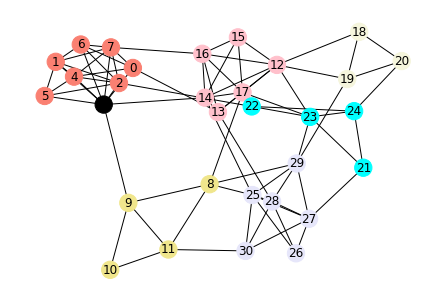

In [ ]:
np.random.seed(1)
central_town = adjacency_matrix.sum(axis=0).argmax()
degree = G.degree(central_town)
print(f"Town {central_town} is our most central town. It has {degree} "
       "connecting roads.")
node_colors[central_town] = 'k'
nx.draw(G, with_labels=True, node_color=node_colors)
plt.show()

_Town 3_ our most central town. How does _Town 3_ compare with the second most central town? We’ll quickly check by outputting the second highest degree in `G`.

**Selecting a node with the second highest degree centrality**

In [ ]:
second_town = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)[1]
second_degree = G.degree(second_town)
print(f"Town {second_town} has {second_degree} connecting roads.")

Town 12 has 8 connecting roads.


_Town 12_ has eight connecting roads. It lags behind _Town 3_ by just one road. What would we do if these two central towns had equal degree rankings? Lets challenge ourselves to find out, by removing an edge connecting _Towns 3_ and _9_.

**Removing an edge from the most central node**

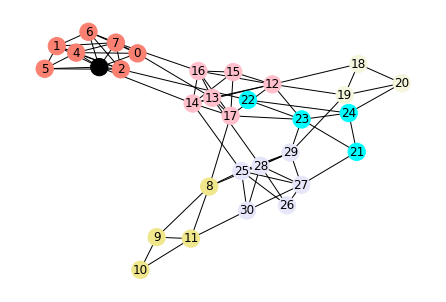

In [ ]:
np.random.seed(1)
G.remove_edge(3, 9)
assert G.degree(3) == G.degree(12)
nx.draw(G, with_labels=True, node_color=node_colors)
plt.show()

Removal of the road has partially isolated _Town 3_ as well as its neighboring towns. Hence, we can expect _Town 12_ to garner more traffic than _Town 3_ , even though their degrees are equal. In fact, we can quantitate these differences in traffic using random simulations.

### Measuring Centrality Using Traffic Simulations

Lets simulate the random path of a single car. The car will start its journey in a random town `i`. Afterwards, the driver will randomly select one of the  `G.degree(i)` roads that cut through town.  The process will repeat itself until the car has driven through 10 towns.

**Simulating the random route of a single car**

In [ ]:
np.random.seed(0)
def random_drive(num_stops=10):
    town = np.random.choice(G.nodes)
    for _ in range(num_stops):
        town = np.random.choice(G[town])
        
    return town

destination = random_drive()
print(f"After driving randomly, the car has reached Town {destination}.")

After driving randomly, the car has reached Town 24.


Now, we’ll repeat this simulation with 20,000 cars.

**Simulating traffic using 20,000 cars**


In [ ]:
import time
np.random.seed(0)
car_counts = np.zeros(len(G.nodes))
num_cars = 20000

start_time = time.time()
for _ in range(num_cars):
    destination = random_drive()
    car_counts[destination] += 1

central_town = car_counts.argmax()
traffic = car_counts[central_town]
running_time = time.time() - start_time
print(f"We ran a {running_time:.2f} second simulation.")
print(f"Town {central_town} has the most traffic.")
print(f"There are {traffic:.0f} cars within that town.")

We ran a 3.63 second simulation.
Town 12 has the most traffic.
There are 1015 cars within that town.


_Town 12_ has the most traffic, with over 1000 cars. This is not surprising, given that _Town 12_ has the highest degree centrality, along with _Town 3_. Based on our previous discussion, we expect _Town 12_ to have more heavy traffic than _Town 3_.

**Checking the traffic in _Town 3_**

In [ ]:
print(f"There are {car_counts[3]:.0f} cars in Town 3.")

There are 934 cars in Town 3.


As expected, _Town 3_ has less than 1000 cars. We should note that car-counts can be cumbersome to compare, especially when `num_cars` is large. Hence, it's preferable to replace these direct counts with probabilities, through division by the simulation count.

**Converting traffic counts to probabilities**

In [ ]:
probabilities = car_counts / num_cars
for i in [12, 3]:
    prob = probabilities[i]
    print(f"The probability of winding up in Town {i} is {prob:.3f}.")

The probability of winding up in Town 12 is 0.051.
The probability of winding up in Town 3 is 0.047.


W’ve shown that _Town 12_ is more central than _Town 3_. Unfortunately, our simulation process is slow, and doesn’t scale well to larger graphs. In the next sub-subsection we’ll show how to compute the traffic probabilities more efficiently using straightforward matrix multiplication.

## Computing Travel Probabilities Using Matrix Multiplication

Our traffic simulation can be modeled mathematically, using matrices and vectors. We’ll break down this process into simple, manageable parts. Consider for instance, a car that is about to leave _Town 0_ for one of the neighboring towns. The probability of traveling from _Town 0_ to any neighboring town is `1 / G.degree(0)`. It is also equal to `1 / M[:,0].sum()`, where `M` is the adjacency matrix.

**Computing the probability of travel to a neighboring town**

In [ ]:
prob_travel = 1 / G.degree(0)
assert prob_travel == 1 / adjacency_matrix[:,0].sum()
print("The probability of traveling from Town 0 to one of its "
      f"{G.degree(0)} neighboring towns is {prob_travel}")

The probability of traveling from Town 0 to one of its 5 neighboring towns is 0.2


If we’re in _Town 0_ and _Town i_ is a neighboring town, then there’s a 20% chance of us traveling from _Town 0_ to _Town i_. Of course, if _Town i_ is not a neighboring town, then the probability drops to zero. We can track the probabilities for every possible `i` using a vector `v`. This vector is called a **transition vector**, since it tracks the probability of transitioning from  _Town 0_  to other towns. 

**Computing a transition vector**

In [ ]:
transition_vector = np.array([0.2 if i in G[0] else 0 for i in G.nodes])

adjacency_matrix = nx.to_numpy_array(G)
v2 = np.array([1 if i in G[0] else 0 for i in G.nodes]) * 0.2
v3 = adjacency_matrix[:,0] * 0.2
v4 = adjacency_matrix[:,0] / adjacency_matrix[:,0].sum()

for v in [v2, v3, v4]:
    assert np.array_equal(transition_vector, v)

print(transition_vector)

[0.  0.  0.  0.2 0.2 0.  0.2 0.2 0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


In [ ]:
assert np.array_equal(transition_vector,
                      adjacency_matrix[:,0] / adjacency_matrix[:,0].sum())

Executing `M / M.sum(axis=0)` will divide each column of the adjacency matrix by the associated degree. The end-result is a matrix whose columns correspond to transition vectors. This matrix is referred to as a **transition matrix**.

**Computing a transition matrix**

In [ ]:
transition_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0)
assert np.array_equal(transition_vector, transition_matrix[:,0])

Our transition matrix allows us to compute the traveling probability to every town in just a few lines of code. If we want to know the probability of winding up in _Town i_ after 10 stops, then we simply need to:

1. Initialize a vector `v` where `v` equals `np.ones(31) / 31`.
2. Update `v` to equal `transition_matrix @ v` over 10 iterations and return `v[i]`.

**Computing travel probabilities using the transition matrix**

In [ ]:
v = np.ones(31) / 31
for _ in range(10):
    v = transition_matrix @ v
    
for i in [12, 3]:
    print(f"The probability of winding up in Town {i} is {v[i]:.3f}.")

The probability of winding up in Town 12 is 0.051.
The probability of winding up in Town 3 is 0.047.


We can model traffic-flow using a series of matrix multiplications. These multiplications serve as the basis for **PageRank centrality**. PageRank centrality is easy to compute, but not so easy to derive. Nonetheless, with basic probability theory, we can demonstrate why repeated `transition_matrix` multiplications directly yield the travel probabilities.

### Deriving PageRank Centrality from Probability Theory

`transition_matrix[i][j]` equals the probability of traveling from _Town j_ directly to _Town i_. Of course, that probability assumes that our car is located in _Town j_. Generally, if the probability of our current location is `p`, then the probability of travel from the current location `j` to new location `i` equals `p * transition_matrix[i][j]`. Suppose a car begins its journey in a random town, and travels one town over. What is the probability that the car will travel from _Town 3_ to _Town 0_ ? Well, the car can start the journey in anyone of 31 different towns. Consequently the probability of traveling from _Town 3_ to _Town 0_ is `transition_matrix[0][3] / 31`. 


**Computing a travel-likelihood from a random starting location**

In [ ]:
prob = transition_matrix[0][3] / 31
print("Probability of starting in Town 3 and driving to Town 0 is "
      f"{prob:.2}")

Probability of starting in Town 3 and driving to Town 0 is 0.004


The probability of that particular path is very low. However, there are multiple paths to reaching _Town 0_ from a random starting location. Lets print all non-zero instances of  `transition_matrix[0][i] / 31` for every possible _Town i_.

**Computing travel likelihoods of random paths leading to _Town 0_**

In [ ]:
for i in range(31):
    prob = transition_matrix[0][i] / 31
    if not prob:
        continue
        
    print(f"Probability of starting in Town {i} and driving to Town 0 is "
          f"{prob:.2}")
    
print("\nAll remaining transition probabilities are 0.0")

Probability of starting in Town 3 and driving to Town 0 is 0.004
Probability of starting in Town 4 and driving to Town 0 is 0.0054
Probability of starting in Town 6 and driving to Town 0 is 0.0065
Probability of starting in Town 7 and driving to Town 0 is 0.0046
Probability of starting in Town 13 and driving to Town 0 is 0.0054

All remaining transition probabilities are 0.0


Five different routes take us to _Town 0_. Each route has a different probability. The sum of these probabilities equals the likelihood of starting at any random town and traveling directly to _Town 0_.

**Computing the probability that the first stop is _Town 0_**

In [ ]:
np.random.seed(0)
prob = sum(transition_matrix[0][i] / 31 for i in range(31))
frequency = np.mean([random_drive(num_stops=1) == 0
                     for _ in range(50000)])

print(f"Probability of making our first stop in Town 0: {prob:.3f}")
print(f"Frequency with which our first stop is Town 0: {frequency:.3f}")

Probability of making our first stop in Town 0: 0.026
Frequency with which our first stop is Town 0: 0.026


Our computed probability is consistent with the observed frequency. It’s worth noting that the probability can be computed more concisely as vector dot product operation. We just need to run `transition_matrix[0] @ v`, where `v` is a 31-element vector whose elements all equal `1 / 31`.

**Computing a travel probability using a vector dot product**

In [ ]:
v = np.ones(31) / 31
assert transition_matrix[0] @ v == prob

Executing `transition_matrix[i] @ v` will return the likelihood of making our first stop in _Town i_. We can compute this likelihood for every town by `[transition_matrix[i] @ v for i in range(31)`. Of course, this operation is equivalent to the matrix product between `transition_matrix` and `v`. Hence, `transition_vector @ v` returns all first-stop probabilities. 


**Computing all first stop probabilities**

In [ ]:
np.random.seed(0)
stop_1_probabilities = transition_matrix @ v
prob = stop_1_probabilities[12]
frequency = np.mean([random_drive(num_stops=1) == 12
                     for _ in range(50000)])

print('First stop probabilities:')
print(np.round(stop_1_probabilities, 3))
print(f"\nProbability of making our first stop in Town 12: {prob:.3f}")
print(f"Frequency with which our first stop is Town 12: {frequency:.3f}")

First stop probabilities:
[0.026 0.033 0.045 0.046 0.033 0.019 0.025 0.038 0.033 0.031 0.019 0.041
 0.052 0.03  0.036 0.019 0.031 0.039 0.023 0.031 0.027 0.019 0.018 0.044
 0.038 0.046 0.015 0.045 0.04  0.035 0.023]

Probability of making our first stop in Town 12: 0.052
Frequency with which our first stop is Town 12: 0.052


We’ve established that `transition_matrix @ v` returns a vector of first stop probabilities. Furthermore, we can easily show that `transition_matrix[i] @ stop_1_probabilities` returns a vector of second-stop probabilities. However,  `stop_1_probabilities` is  equal to `transition_matrix @ v`. Consequently, the second-stop probabilities are also equal to `transition_matrix @ transition_matrix @ v`. 

**Computing all second stop probabilities**

In [ ]:
np.random.seed(0)
stop_2_probabilities = transition_matrix @ transition_matrix @ v
prob = stop_2_probabilities[12]
frequency = np.mean([random_drive(num_stops=2) == 12
                     for _ in range(50000)])

print('Second stop probabilities:')
print(np.round(stop_2_probabilities, 3))
print(f"\nProbability of making our second stop in Town 12: {prob:.3f}")
print(f"Frequency with which our second stop is Town 12: {frequency:.3f}")

Second stop probabilities:
[0.027 0.033 0.038 0.043 0.033 0.023 0.028 0.039 0.039 0.026 0.021 0.032
 0.048 0.034 0.039 0.023 0.032 0.041 0.023 0.029 0.025 0.024 0.023 0.04
 0.029 0.043 0.021 0.036 0.036 0.042 0.031]

Probability of making our second stop in Town 12: 0.048
Frequency with which our second stop is Town 12: 0.048


We were able to derive our second-stop probabilities directly from our first stop probabilities. If we repeat our derivation, then we can easily show that `stop_3_probabilities` equals  `transition_matrix @ stop_2_probabilities`.  Of course, this vector also equals `M @ M @ M @ v`, where `M` is the transition matrix.  We can repeat this process to compute the fourth-stop probabilities, and then fifth-stop probabilities, and eventually the Nth stop-probabilities.  

**Computing the Nth-stop probabilities**

In [ ]:
def compute_stop_likelihoods(M, num_stops):
    v = np.ones(M.shape[0]) / M.shape[0]
    for _ in range(num_stops):
        v = M @ v
        
    return v
    

stop_10_probabilities = compute_stop_likelihoods(transition_matrix, 10)
prob = stop_10_probabilities[12]
print('Tenth stop probabilities:')
print(np.round(stop_10_probabilities, 3))
print(f"\nProbability of making our tenth stop in Town 12: {prob:.3f}")

Tenth stop probabilities:
[0.029 0.035 0.041 0.047 0.035 0.023 0.029 0.041 0.034 0.021 0.014 0.028
 0.051 0.038 0.044 0.025 0.037 0.045 0.02  0.026 0.02  0.02  0.019 0.039
 0.026 0.047 0.02  0.04  0.04  0.04  0.027]

Probability of making our tenth stop in Town 12: 0.051


As we’ve discussed, our iterative matrix multiplications form the basis for PageRank centrality. 

### Computing PageRank Centrality Using NetworkX
A function to compute PageRank centrality is included in NetworkX.

**Computing PageRank centrality using NetworkX**

In [ ]:
centrality = nx.pagerank(G)[12]
print(f"The PageRank centrality of Town 12 is {centrality:.3f}.")

The PageRank centrality of Town 12 is 0.048.


The printed PageRank value is 0.048, which is slightly lower than expected. This is due to the concept of _teleportation_ which is built into the PageRank algorithm. The algorithm assumes that a traveller will teleport to random node in 15% of all transitions. Imagine that in 15% of our town visits, we call for a helicopter, which takes us to a totally random town. Hence, 15% of the time, we’ll fly from _Town i_ to _Town j_ with a probability of `1 / 31`. In the remaining 85% of instances, we’ll drive from _Town i_ to _Town j_ with a probability of `transition_matrix[j][i]`. Consequently, the actual probability of travel from _i_ to _j_ equals the weighted mean of `transition_matrix[j][i]` and `1 / 31`.  Taking the weighted across all elements of the transition matrix will produce an entirely new transition matrix. Below, we’ll update our transition matrix, and recompute the _Town 12’s_ travel probability. 

**Incorporating randomized teleportation into our model**

In [ ]:
new_matrix = 0.85 * transition_matrix + 0.15 / 31
stop_10_probabilities = compute_stop_likelihoods(new_matrix, 10)

prob = stop_10_probabilities[12]
print(f"The probability of winding up in Town 12 is {prob:.3f}.")

The probability of winding up in Town 12 is 0.048.


Our new output is consistent with the NetworkX result. Will that output remain consistent if we raise the number of stops from 10 to 1000? Lets find out.

**Computing the probability after 1000 stops**

In [ ]:
prob = compute_stop_likelihoods(new_matrix, 1000)[12]
print(f"The probability of winding up in Town 12 is {prob:.3f}.")

The probability of winding up in Town 12 is 0.048.


The centrality remains consistent 0.048. Ten iterations are usually sufficient to achieve PageRank convergence. Transition / Markov matrices have mathematical properties. Markov matrices bridge graph theory with probability theory and matrix theory. However, that’s not all. Markov matrices can also be leveraged to cluster network data, using a procedure called **Markov clustering**.

## Community Detection Using Markov Clustering

Graph `G` represents a network of towns. Some of these fall into localized counties. Thus far, we’ve visualized the counties by mapping colors to individual county ids. What if we didn’t know the county ids? How would we identify the counties? Lets ponder this question by visualizing `G` without any sort of color mapping.

**Plotting `G` without county-based coloring**

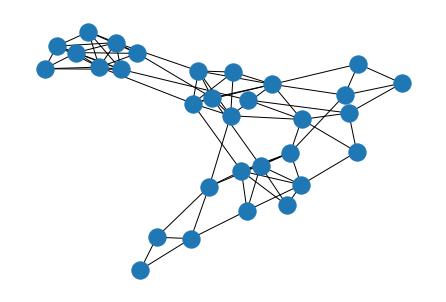

In [ ]:
np.random.seed(1)
nx.draw(G)
plt.show()

Our plotted graph has neither colors nor labels. Still, we can spot potential counties. They look like tightly connected clusters of nodes within the network. In graph theory, such clusters are formally referred to as **communities**. The process of uncovering communities in graphs is called **community detection**, or **graph clustering**. Some graph clustering algorithms depend on simulations of traffic-flow.

Suppose we drive from _Town i_ to _Town j_ and then to _Town k_. Based on our network structure, _Towns i_ and _k_ are more likely to be in the same county, We will confirm this statement shortly. However, first we’ll need to compute the probability of transition from _Town i_ to _Town k_ after two stops. This probability is called the **stochastic flow**, or **flow** for short.  We’ll need to calculate the flow between each pair of towns, and store that output in a **flow matrix**. The flow matrix is equal to `transition_matrix @ transition_matrix`. Hence, a random simulation should approximate the product of the transition matrix with itself.

**Comparing computed flow to random simulations**

In [ ]:
np.random.seed(1)
flow_matrix = transition_matrix @ transition_matrix

simulated_flow_matrix = np.zeros((31, 31))
num_simulations = 10000
for town_i in range(31):
    for _ in range(num_simulations):
        town_j = np.random.choice(G[town_i])
        town_k = np.random.choice(G[town_j])
        simulated_flow_matrix[town_k][town_i] += 1

simulated_flow_matrix /= num_simulations
assert np.allclose(flow_matrix, simulated_flow_matrix, atol=1e-2)

We believe that the average flow between _Towns i_ and _j_ is higher if `G.nodes[i]['county_id']` equals `G.nodes[j]['country_id']`. We can confirm by separating all flows into two lists; `county_flows` and `between_county_flows`. The two lists will track intra-county flows and inter-county flows, respectively. We’ll plot a histogram for each of the lists. We’ll also compare their mean flow values. 


**Comparing intra and inter-county flow distributions**

Mean flow within a county: 0.116
Mean flow between different counties: 0.042
The minimum intra-county flow is approximately 0.042
132 inter-county flows fall below that threshold.


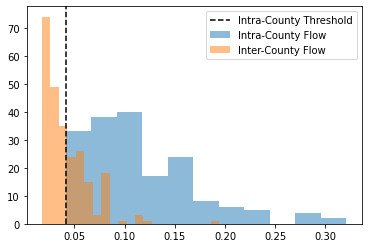

In [ ]:
def compare_flow_distributions():
    county_flows = [] 
    between_county_flows = []
    for i in range(31):
        county = G.nodes[i]['county_id']
        nonzero_indices = np.nonzero(flow_matrix[:,i])[0]
        for j in nonzero_indices:
            flow = flow_matrix[j][i]
            
            if county == G.nodes[j]['county_id']:
                county_flows.append(flow)
            else:
                between_county_flows.append(flow)
    
    mean_intra_flow = np.mean(county_flows)
    mean_inter_flow = np.mean(between_county_flows)
    print(f"Mean flow within a county: {mean_intra_flow:.3f}")
    print(f"Mean flow between different counties: {mean_inter_flow:.3f}")
    
    threshold = min(county_flows)
    num_below = len([flow for flow in between_county_flows
                     if flow < threshold])
    print(f"The minimum intra-county flow is approximately {threshold:.3f}")
    print(f"{num_below} inter-county flows fall below that threshold.")
    
    plt.hist(county_flows, bins='auto',  alpha=0.5, 
             label='Intra-County Flow')
    plt.hist(between_county_flows,  bins='auto', alpha=0.5, 
             label='Inter-County Flow')
    plt.axvline(threshold, linestyle='--', color='k',
                label='Intra-County Threshold')
    plt.legend()
    plt.show()
    
compare_flow_distributions()

Flows below a threshold of approximately 0.04 are guaranteed to represent inter-county values. Of course, we’re only able to observe this threshold due to our advance knowledge of county identities. In a real-word scenario, the actual county ids would not be known. We’d be forced to assume that the cutoff is a low-value, like 0.01. Suppose we made that assumption with our data. How many non-zero inter-county flows are less than 0.01?

**Decreasing the separation threshold**

In [ ]:
num_below = np.count_nonzero((flow_matrix > 0.0) & (flow_matrix < 0.01))
print(f"{num_below} inter-county flows fall below a threshold of 0.01")

0 inter-county flows fall below a threshold of 0.01


None of the flow values fall below the stringent threshold of 0.01. We need to manipulate the flow distribution in order to exaggerate the difference between large and small values. This manipulation can be carried out with a simple process called **inflation**. Inflation is intended to influence the values of a vector while keeping its mean constant. We can inflate a vector `v` by executing `v2 = v **2` and subsequently dividing `v2` by `v2.sum()`.

**Exaggerating value differences through vector inflation**

In [ ]:
v = np.array([0.7, 0.3])
v2 = v ** 2
v2 /= v2.sum()
assert v.mean() == round(v2.mean(), 10)
assert v2[0] > v[0]
assert v2[1] < v[1]

Like vector `v`, the columns of our flow matrix are vectors whose elements sum to 1. We can inflate each column by squaring its elements, and then dividing by the subsequent column sum.

**Exaggerating flow differences through vector inflation**

Mean flow within a county: 0.146
Mean flow between different counties: 0.020
The minimum intra-county flow is approximately 0.012
118 inter-county flows fall below that threshold.


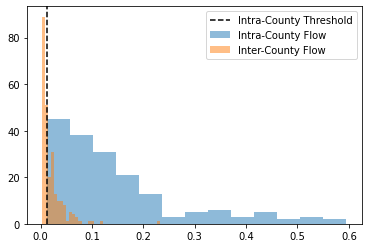

In [ ]:
def inflate(matrix):
    matrix = matrix ** 2
    return matrix / matrix.sum(axis=0)

flow_matrix = inflate(flow_matrix)
compare_flow_distributions()

Our threshold has decreased from 0.042 to 0.012. However, it still remains above 0.01. How do we further exaggerate the difference between inter-county and intra-county edges? Well, setting the flow matrix to equal `inflate(flow_matrix @ flow_matrix)` will cause the threshold to drastically decrease. 

**Inflating the product of `flow_matrix` with itself**

Mean flow within a county: 0.159
Mean flow between different counties: 0.004
The minimum intra-county flow is approximately 0.001
541 inter-county flows fall below that threshold.


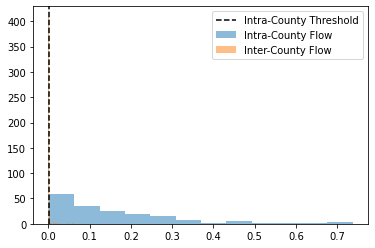

In [ ]:
flow_matrix = inflate(flow_matrix @ flow_matrix)
compare_flow_distributions()

This serves as the basis for a network clustering algorithm known as the **Markov Cluster Algorithm**. It is also referred to as **Markov clustering**, or **MCL** for short. MCL is executed by running `inflate(flow_matrix @ flow_matrix)` over many repeating iterations. We’ll now attempt to execute MCL. To start, we’ll run `flow_matrix = inflate(flow_matrix @ flow_matrix)` across 20 iterations.

**Inflating the product of `flow_matrix` repeatedly with itself**

In [ ]:
for _ in range(20):
    flow_matrix = inflate(flow_matrix @ flow_matrix)

Certain edges in graph `G` should now have a flow of zero. We expect these edges to connect diverging counties. 

**Selecting suspected inter-county edges**

In [ ]:
suspected_inter_county = [(i, j) for (i, j) in G.edges()
                         if not (flow_matrix[i][j] or flow_matrix[j][i])]
num_suspected = len(suspected_inter_county)
print(f"We suspect {num_suspected} edges of appearing between counties.")

We suspect 57 edges of appearing between counties.


Deleting the suspected edges from our graph should sever all cross-county connections. Consequently, only clustered counties should remain if we visualize the graph after edge deletion.

**Deleting suspected inter-county edges**

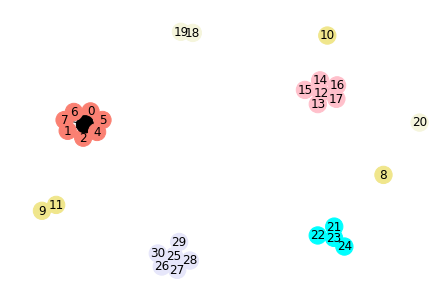

In [ ]:
np.random.seed(1)
G_copy = G.copy()
G_copy.remove_edges_from(suspected_inter_county)
nx.draw(G_copy, with_labels=True, node_color=node_colors)
plt.show()

All inter-county edges have been eliminated. Unfortunately, a few key intra-county edges have also been deleted. The problem is due to a minor error in our model. The model assumes that travelers can drive to neighboring towns, but it does not allow a traveller to remain in their current location. Adding self-loops to a graph will limit the unexpected model behaviour. Lets illustrate the impact of self-loops in a simple two-node adjacency matrix.

**Improving flow by adding self-loops**

In [ ]:
def compute_flow(adjacency_matrix):
    transaction_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0)
    return (transaction_matrix @ transaction_matrix)[1][0]

M1 = np.array([[0, 1], [1, 0]])
M2 = np.array([[1, 1], [1, 1]])
flow1, flow2 = [compute_flow(M) for M in [M1, M2]]
print(f"The flow from A to B without self-loops is {flow1}")
print(f"The flow from A to B with self-loops is {flow2}")

The flow from A to B without self-loops is 0.0
The flow from A to B with self-loops is 0.5


Adding self-loops to graph `G` should limit inappropriate edge deletions. With this in mind, lets now define a `run_mcl` function.

**Defining an MCL function**

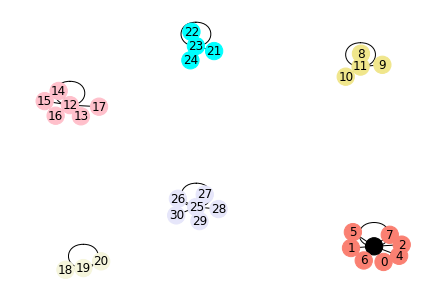

In [ ]:
def run_mcl(G):
    for i in G.nodes:
        G.add_edge(i, i)
    
    adjacency_matrix = nx.to_numpy_array(G)
    transition_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0)
    flow_matrix = inflate(transition_matrix @ transition_matrix)
    
    for _ in range(20):
        flow_matrix = inflate(flow_matrix @ flow_matrix)
      
    G.remove_edges_from([(i, j) for i, j in G.edges()
                        if not (flow_matrix[i][j] or flow_matrix[j][i])])

G_copy = G.copy()
run_mcl(G_copy)
nx.draw(G_copy, with_labels=True, node_color=node_colors)
plt.show()

Our graph has clustered perfectly into six secluded counties. In graph theory, such isolated clusters are referred to as **connected components**. In order to compute the full component of a node, it is sufficient to run `nx.shortest_path_length` on that node. The shortest path length algorithm will return only those nodes that are accessible within a clustered community. 

**Using path lengths to uncover a county cluster**

In [ ]:
component = nx.shortest_path_length(G_copy, source=0).keys()
county_id = G.nodes[0]['county_id']
for i in component:
    assert G.nodes[i]['county_id'] == county_id
    
print(f"The following towns are found in County {county_id}:")
print(sorted(component))

The following towns are found in County 0:
[0, 1, 2, 3, 4, 5, 6, 7]


With minor modifications to the shortest path length algorithm, we can extract a graph’s connected components. This modified component algorithm is incorporated into NetworkX.

**Extracting all the clustered connected components**

In [ ]:
for component in nx.connected_components(G_copy):
    county_id = G.nodes[list(component)[0]]['county_id']
    print(f"\nThe following towns are found in County {county_id}:")
    print(component)


The following towns are found in County 0:
{0, 1, 2, 3, 4, 5, 6, 7}

The following towns are found in County 1:
{8, 9, 10, 11}

The following towns are found in County 2:
{12, 13, 14, 15, 16, 17}

The following towns are found in County 3:
{18, 19, 20}

The following towns are found in County 4:
{24, 21, 22, 23}

The following towns are found in County 5:
{25, 26, 27, 28, 29, 30}


Our MCL implementation will not scale to very large networks. Further optimizations are required for successful scaling. These optimizations have been integrated into the external Markov Clustering library.

**Importing from the Markov Clustering library**

In [ ]:
!pip install -q markov_clustering

In [ ]:
import markov_clustering
from markov_clustering import get_clusters, run_mcl

Given an adjacency matrix `M`, we can efficiently execute Markov clustering by running `get_clusters(run_mcl(M))`.

**Clustering with the Markov Clustering library**

In [ ]:
adjacency_matrix = nx.to_numpy_array(G)
clusters = get_clusters(run_mcl(adjacency_matrix))

for cluster in clusters:
    county_id = G.nodes[cluster[0]]['county_id']
    print(f"\nThe following towns are found in County {county_id}:")
    print(cluster)


The following towns are found in County 0:
(0, 1, 2, 3, 4, 5, 6, 7)

The following towns are found in County 1:
(8, 9, 10, 11)

The following towns are found in County 2:
(12, 13, 14, 15, 16, 17)

The following towns are found in County 3:
(18, 19, 20)

The following towns are found in County 4:
(21, 22, 23, 24)

The following towns are found in County 5:
(25, 26, 27, 28, 29, 30)


With Markov clustering, we can efficiently detect communities in community-structured graphs. This will prove useful when we search for groups of friends in social networks

## Uncovering Friend Groups in Social Networks

We can represent many processes as networks, including relationships between people. Within these **social networks**, nodes represent individual people. One famous social network is called _Zachery’s Karate Club_. That network can be loaded from NetworkX.

**Loading the Karate Club graph**

In [ ]:
G_karate = nx.karate_club_graph()
print(G_karate.nodes(data=True))

[(0, {'club': 'Mr. Hi'}), (1, {'club': 'Mr. Hi'}), (2, {'club': 'Mr. Hi'}), (3, {'club': 'Mr. Hi'}), (4, {'club': 'Mr. Hi'}), (5, {'club': 'Mr. Hi'}), (6, {'club': 'Mr. Hi'}), (7, {'club': 'Mr. Hi'}), (8, {'club': 'Mr. Hi'}), (9, {'club': 'Officer'}), (10, {'club': 'Mr. Hi'}), (11, {'club': 'Mr. Hi'}), (12, {'club': 'Mr. Hi'}), (13, {'club': 'Mr. Hi'}), (14, {'club': 'Officer'}), (15, {'club': 'Officer'}), (16, {'club': 'Mr. Hi'}), (17, {'club': 'Mr. Hi'}), (18, {'club': 'Officer'}), (19, {'club': 'Mr. Hi'}), (20, {'club': 'Officer'}), (21, {'club': 'Mr. Hi'}), (22, {'club': 'Officer'}), (23, {'club': 'Officer'}), (24, {'club': 'Officer'}), (25, {'club': 'Officer'}), (26, {'club': 'Officer'}), (27, {'club': 'Officer'}), (28, {'club': 'Officer'}), (29, {'club': 'Officer'}), (30, {'club': 'Officer'}), (31, {'club': 'Officer'}), (32, {'club': 'Officer'}), (33, {'club': 'Officer'})]


Our nodes track 34 people. Each node has a `club` attribute. That attribute is set to _Mr. Hi_ if the person joined Mr. Hi’s karate club. Otherwise, it’s set to _Officer_.  Lets go ahead and visualize the network.

**Visualizing the Karate Club graph**

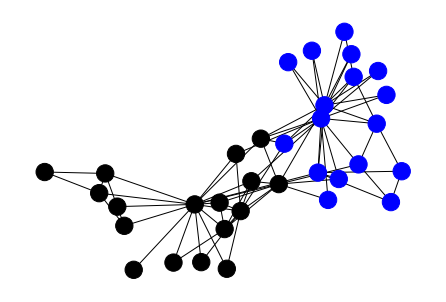

In [ ]:
np.random.seed(2)
club_to_color = {'Mr. Hi': 'k', 'Officer': 'b'}
node_colors = [club_to_color[G_karate.nodes[i]['club']] 
               for i in G_karate]

nx.draw(G_karate, node_color=node_colors)
plt.show()

The Karate Club graph has a clear community structure. The colored clusters represent existing friend-groups. Lets extract these clusters using MCL.

**Clustering the Karate Club graph**

In [ ]:
adjacency_matrix = nx.to_numpy_array(G_karate)
clusters = get_clusters(run_mcl(adjacency_matrix))
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}:\n{cluster}\n")

Cluster 0:
(0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21)

Cluster 1:
(2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33)



Two clusters have been outputted as expected. We’ll now re-plot the graph, while coloring each node by cluster id.

**Coloring the plotted graph by cluster**

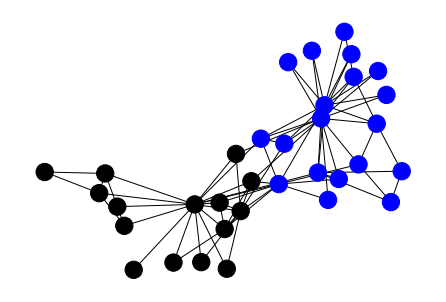

In [ ]:
np.random.seed(2)
cluster_0, cluster_1 = clusters
node_colors = ['k' if i in cluster_0 else 'b'
               for i in G_karate.nodes]

nx.draw(G_karate, node_color=node_colors)
plt.show()

Our clusters are nearly identical to the two splintered clubs. MCL has capably extracted the friend groups in the social network. The code below will illustrate how to color friend-groups in an automated manner.

**Coloring social graph clusters automatically**

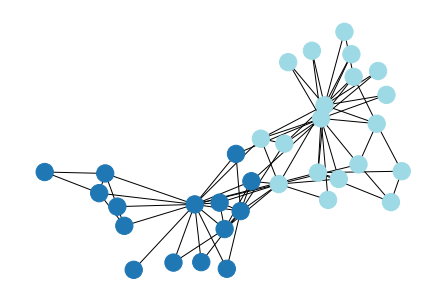

In [ ]:
np.random.seed(2)
for cluster_id, node_indices in enumerate(clusters):
    for i in node_indices:
        G_karate.nodes[i]['cluster_id'] = cluster_id
        
node_colors = [G_karate.nodes[n]['cluster_id'] for n in G_karate.nodes]
nx.draw(G_karate, node_color=node_colors, cmap=plt.cm.tab20)
plt.show()

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-11-21 15:52:51

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

networkx         : 2.6.3
markov_clustering: 0.0.6.dev0
numpy            : 1.19.5
IPython          : 5.5.0
matplotlib       : 3.2.2



---